# REMclust
---
### Introduction

REMclust is a python package for model-based clustering based on finite normal mixture modelling. It uses a peak finding criterion to find modes within the data set. An initial mode set is taken to be the means in Gaussian components.

Once the initial mode set has been selected, an iterative proceedure comprising of two blocks are triggered:
1. An EM block to fit the covariances and mixing proportions of the components
2. A pruning block to remove one of the components, as part of an effeicent model selection strategy.

Additional functionalities are available for displaying and visualizing fitted models along with clustering results.

---
### Data

The data set used in this vignettee is the [Palmer Archipelago (Antarctica) Penguin Data](https://github.com/allisonhorst/palmerpenguins). The following methods are used simply to load the dataset.

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from REM import REM
from sklearn import preprocessing


In [25]:
data = np.genfromtxt('Data/penguin.csv', delimiter=",")
x = data[:, 1:]
y = data[:, 0]
labels = x[0, :]
x = x[1:,:]
scaler = preprocessing.StandardScaler().fit(x)
x = scaler.transform(x)

n_samples, n_features = x.shape

In [26]:
def plot_data_for_exploration(dimensions, data):
    fig, axs = plt.subplots(dimensions, dimensions, figsize=(15, 8))
    for i in range(dimensions):
        for j in range(dimensions):
            if i != j:
                axs[j][i].scatter(data[:,i], data[:,j], s=5)
            else:
                axs[i][i].scatter(data[:, i], data[:, i], marker="none")
    for ax in fig.get_axes():
        ax.label_outer()
                

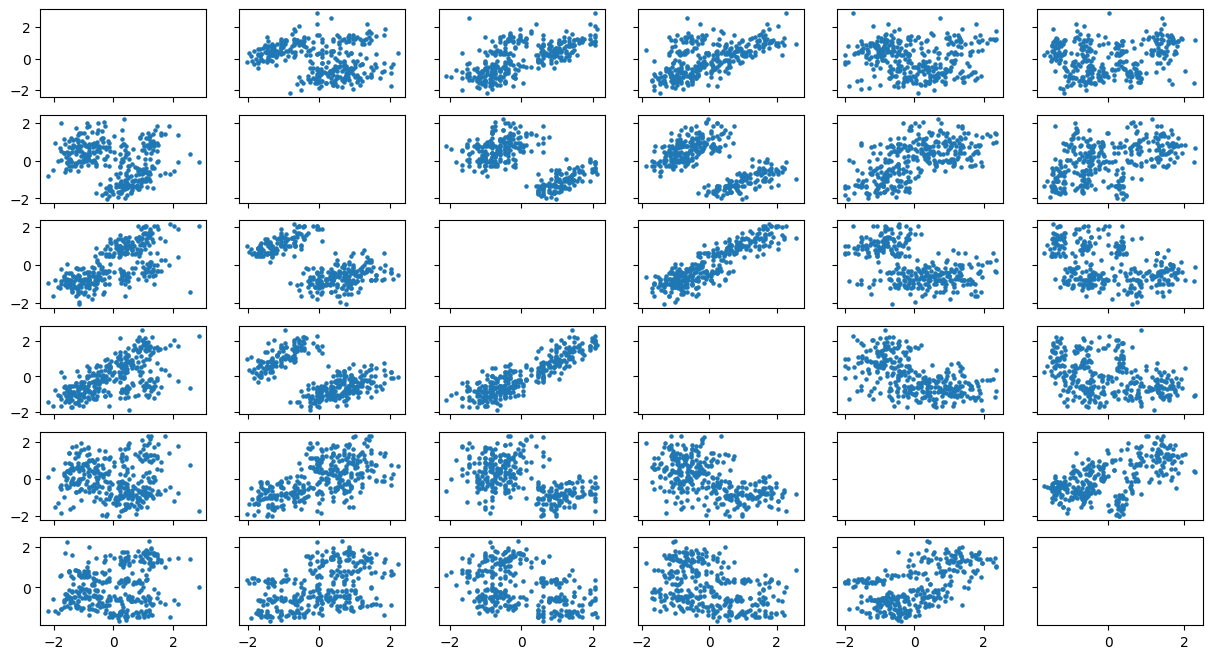

In [27]:
plot_data_for_exploration(n_features, x)

### Initialisation
The first step in applying REM to the data set is to initialise an REM object.
```python
REM(data, covariance_type='full', criteria='all', bandwidth='diagonal', tol=1e-3, reg_covar=1e-6, max_iter=100)
```
- **data (array-like of shape (n_samples, n_features))**: The data the model is being fitted to.
- **covariance_type {'full', 'tied', 'diag', 'spherical'}**: A string describing the type of covariance parameters to use.
- **criteria {'all', 'aic', 'bic', 'icl'}**: A string defining the criterion score used in model selection.
- **bandwidth ({'diagonal', 'spherical', 'normal_reference'}, int, float)**: Either a string, integer, or floating point number that defines the bandwidth used when finding the modes.
- **tol (float)**: The convergence threshold. EM iterations will stop when the lower bound average gain is below this threshold.
- **reg_covar (float)**: Non-negative regularization added to the diagonal of covariance. Allows to assure that the covariance matrices are all positive.
- **max_iter (int)**: The number of EM iterations to perform.

In [28]:
cluster = REM.REM(data=x, covariance_type="full", criteria="icl",bandwidth='normal_reference', tol=1e-4)

### Mode Selection

The initial mode set must be selected by the user. To do this, they must select a *distance_threshold* and *density_threshold*. To aid in this, the method
```python
REM.plot_exemplars()
```
is provided. This draws two plots, one is a plot of the distance between a point to its nearest neighbor with a higher density against the points' density. This plot will allow the user to select the appropriate thresholds. The ideal modes have both a high distance and density. The second plot shows the product of the distance and the density for each point, allowing the user to clearly the likely number of modes.

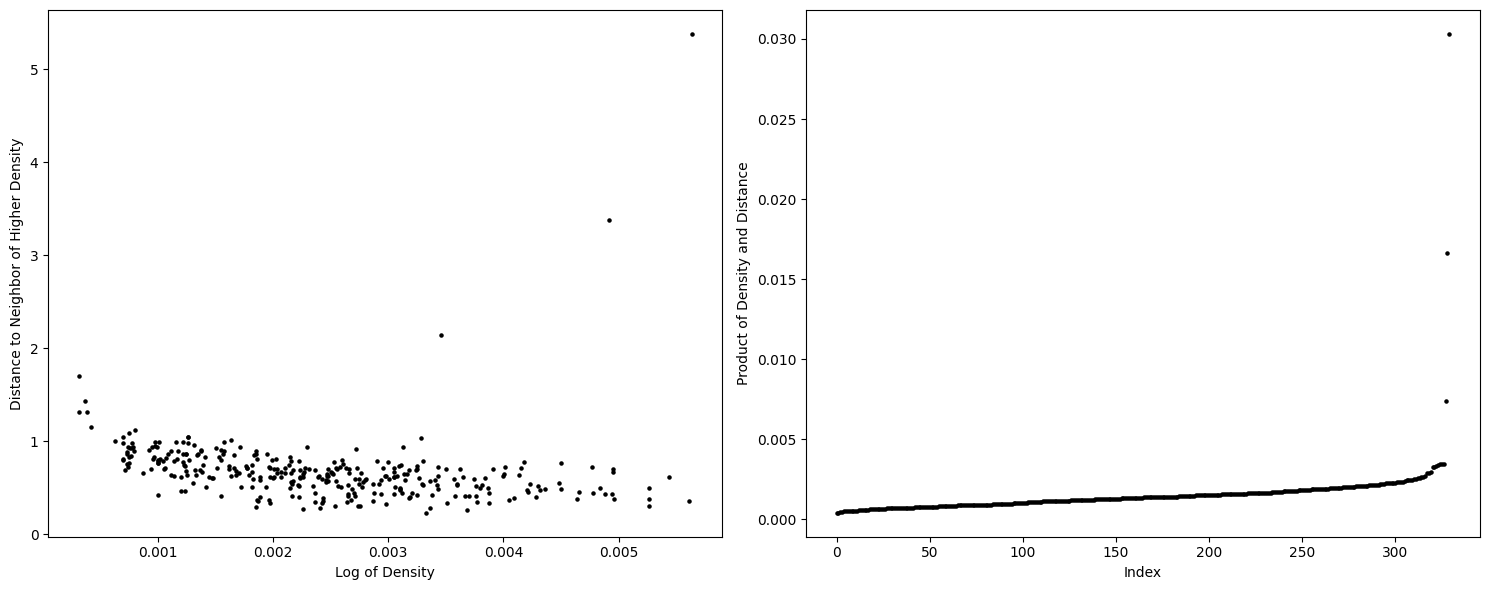

In [29]:
cluster.plot_exemplars()

REMclust also provides the method:
```python
REM.density_plot(dimensions=None, axis_labels=None)
```
- **dimensions (list(int))**: A list of integers that defines the features that will be plotted. If left as None all features will be plotted.
- **axis_labels (list(str))**: A list of strings that define the labels for the axes.

This provides a contour plot of the estimated KDE densities.

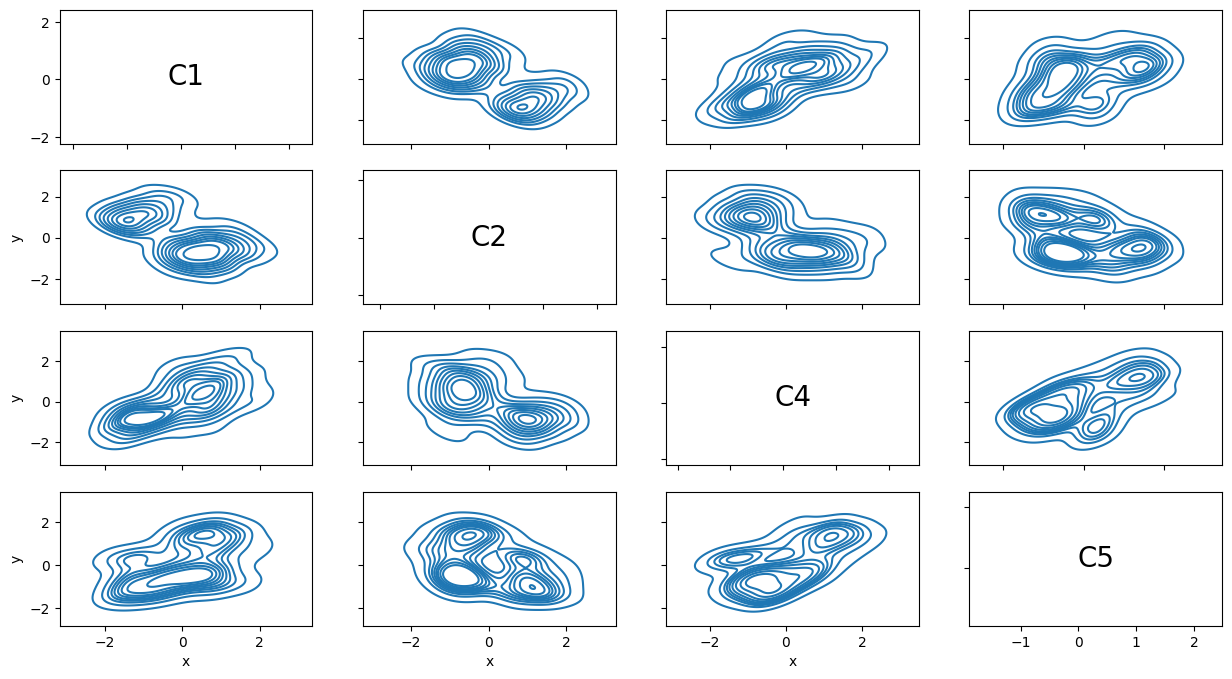

In [30]:
cluster.density_plot(dimensions=[1, 2, 4, 5])

### Clustering

To perform clustering, the following method is run:
```python
fit(max_components=5, density_threshold=None, distance_threshold=None)
```
- **max_components (int)**: An integer that defines the initial size of the mode set. The modes with the highest $density \times distance$ will fill the set.
- **density_threshold (float)**: A float that defines the threshold for the mode's density. A mode must have a higher density to be included in the initial mode set.
- **distance_threshold (float)**: A float that defines the threshold for the mode's distance. A mode must have a higher distance to be included in the initial mode set.

**Note:** There are two possible ways to define the mode set:
1. Setting the max components value k, in which the k modes with the highest $density \times distance$ will be included in the initial mode set.
2. Setting the two thresholds, in which the modes that exceed both thresholds will be included in the initial mode set.

Should the user set the max components and the thresholds, the mode set created by the thresholds will be preferred.

In [31]:
cluster.fit(distance_threshold=2, density_threshold=0.003)

3 means selected.


### Visualisation

REMclust provides visualisation tools that allow the user to explore results of the clustering. The first of these is:
```python
REM.classification_plot(mixture_selection='', dimensions=None, axis_labels=None)
```
A plot of the classification of the data that the clustering was performed on.
- **mixture_selection {'', 'aic', bic', 'icl'}** This defines whether the user would like plot the results from the model selected by AIC, BIC, or ICL. If the initial criterion was set to 'all', this is required, otherwise it should not be set.
- **dimensions (list(int))**: A list of integers that defines the features that will be plotted. If left as None all features will be plotted.
- **axis_labels (list(str))**: A list of strings that define the labels for the axes.

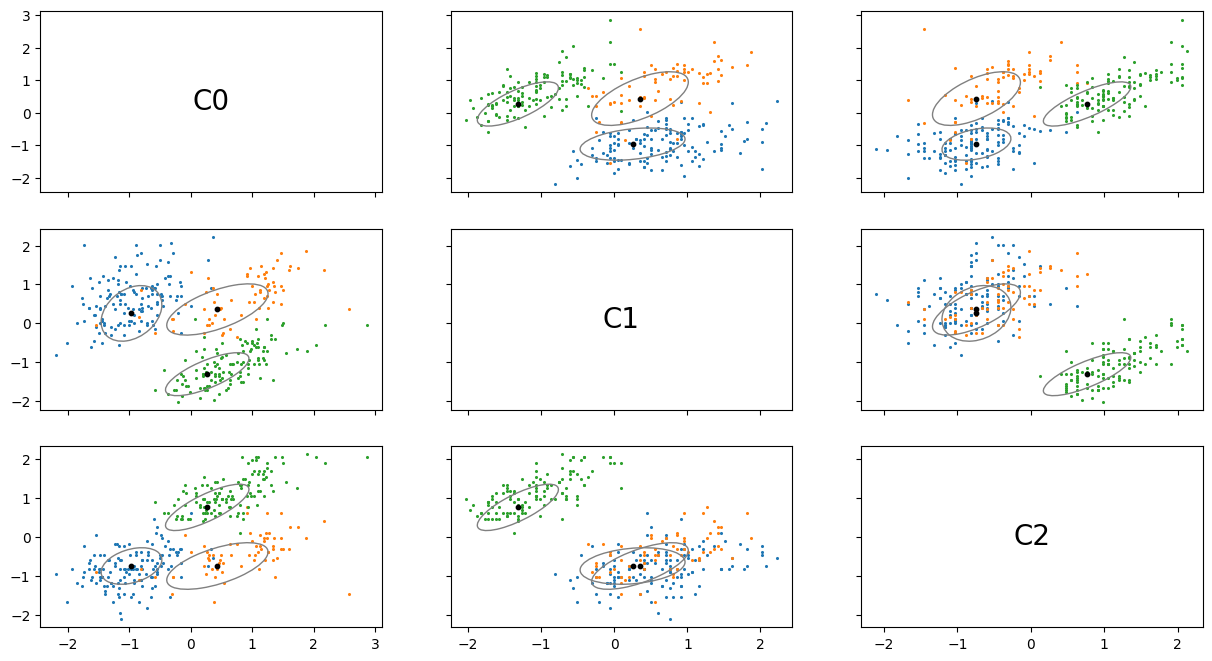

In [32]:
cluster.classification_plot(dimensions=[0,1,2])

Another visualisation method provided by REMclust is:
```python
REM.uncertainty_plot(mixture_selection='', dimensions=None, axis_labels=None)
```
A plot of the uncertainty of the data that the clustering was performed on.
- **mixture_selection {'', 'aic', bic', 'icl'}** This defines whether the user would like plot the results from the model selected by AIC, BIC, or ICL. If the initial criterion was set to 'all', this is required, otherwise it should not be set.
- **dimensions (list(int))**: A list of integers that defines the features that will be plotted. If left as None all features will be plotted.
- **axis_labels (list(str))**: A list of strings that define the labels for the axes.

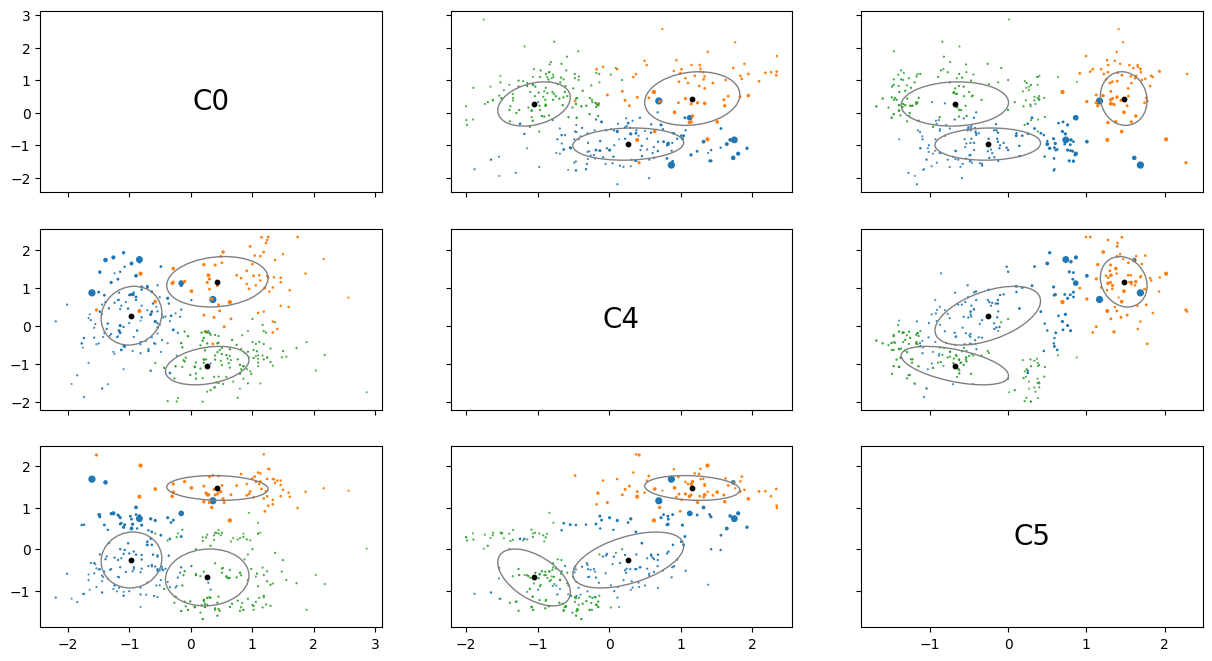

In [33]:
cluster.uncertainty_plot(dimensions=[0,4,5])

Finally, REMclust provides:
```python
REM.criterion_plot()
```
A plot of the criterion scores for the different models fit

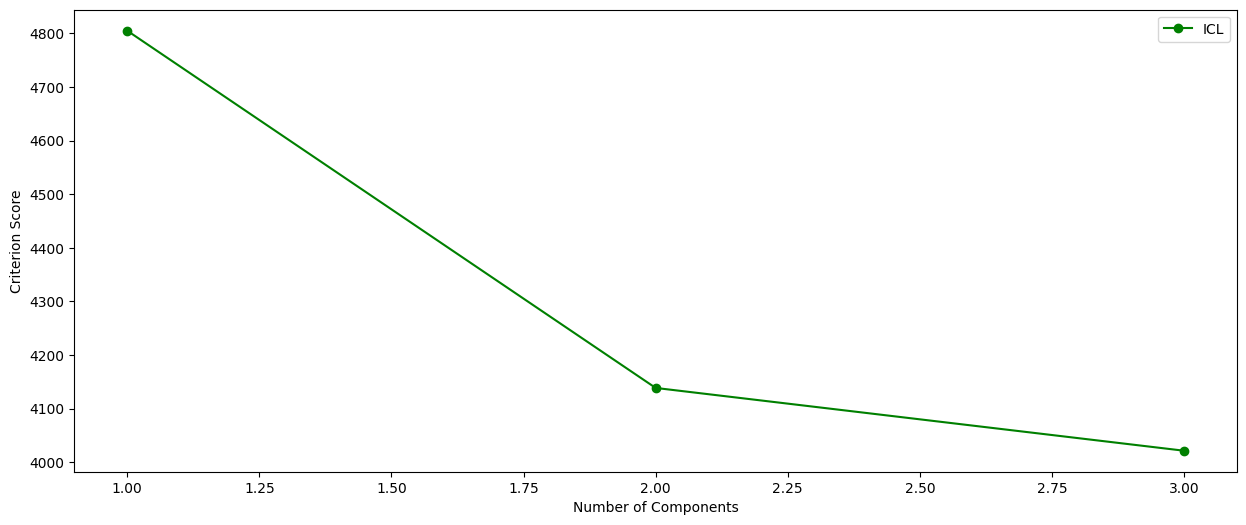

In [34]:
cluster.criterion_plot()

### Summary
As well as visualisations, REMclust also provides a method that prints text based summaries of the clustering results.
```python
REM.summary(parameters=False, classification=False, criterion_scores=False)
```
- **parameters (boolean)**: If TRUE, the parameters of mixture components are printed.
- **classification (boolean)**: If TRUE, a table of classifications/clustering of observations is printed.
- **criterion_scores (boolean)**: If TRUE, the criterion scores of all the models tested are printed.

In [35]:
cluster.summary(parameters=True, classification=True, criterion_scores=True)

ICL scores:
Number of components      ICL            
1                         4805.1786431394385
2                         4138.741124624213
3                         4021.5939101029207

REM full model with 3 components.

Log-Likelihood            n     ICL            
-5.367678926793543        330   4805.1786431394385

Clustering Table:
   0   1   2
 138  70 122

Mixing proportions:
                     0                     1                     2
    0.4147769179028345    0.2151925323535864    0.3700305497435792

Means:
        [,0]  [,1]  [,2]  [,3]  [,4]  [,5]
  [0,]-0.9648175038756760.25032265970970247-0.7396808746149706-1.17029532307836350.2679057507786277-0.260936435380193
  [1,]0.43259662162686010.35155608826877266-0.7396808746149706-0.64164110273295551.162223908617081.4778133984144206
  [2,]0.26711336992261264-1.31879548295589190.76663368932324450.6644457945909935-1.0486229298720295-0.6815933154082421

Variances:
[0,,]
                                    [,0]               